# ONNX 检测演示

这个 notebook 支持：
- 指定文件夹图片检测
- 读取 JetRacer/普通摄像头进行检测


In [10]:
from pathlib import Path
import importlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

import onnx_detector
importlib.reload(onnx_detector)
from onnx_detector import (
    OnnxYoloDetector,
    draw_detections,
    load_class_names,
)


In [ ]:
# 路径配置
cwd = Path.cwd()
repo_root = cwd

onnx_path = repo_root / 'yolo26n.onnx'  # 修改为你的 ONNX 模型路径
classes_path = repo_root / 'classes.txt'

conf_thres = 0.25
iou_thres = 0.45
imgsz = 640  # 例如 (640, 640) 或 640
measure_time = True  # True 时打印推理耗时与 FPS

use_tensorrt = True
trt_fp16 = True
trt_cache_path = repo_root / "trt_cache"
trt_workspace_mb = 2048
cuda_device_id = 0

providers = None
if use_tensorrt:
    providers = [
        ("TensorrtExecutionProvider", {
            "trt_fp16_enable": trt_fp16,
            "trt_engine_cache_enable": True,
            "trt_engine_cache_path": str(trt_cache_path),
            "trt_max_workspace_size": trt_workspace_mb * 1024 * 1024,
        }),
        ("CUDAExecutionProvider", {"device_id": cuda_device_id}),
    ]

detector = OnnxYoloDetector(
    onnx_path,
    class_names=load_class_names(classes_path),
    conf_thres=conf_thres,
    iou_thres=iou_thres,
    input_size=imgsz,
    providers=providers,
)


In [13]:
def show_bgr(image_bgr, title=None):
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    if title:
        plt.title(title)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


## 单张图片检测

In [14]:
image_path = repo_root / 'test_images' / 'collect1_frame_000861.jpg'
image = cv2.imread(str(image_path))
if image is None:
    raise FileNotFoundError(image_path)

detections = detector.predict(image, measure_time=measure_time)
if measure_time and detector.last_inference_time is not None:
    inf_ms = detector.last_inference_time * 1000.0
    fps = 1.0 / detector.last_inference_time if detector.last_inference_time > 0 else float("inf")
    print(f"Inference: {inf_ms:.2f} ms | FPS: {fps:.2f}")
vis = detector.visualize(image, detections)
show_bgr(vis, title=f'dets: {len(detections)}')


InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: images for the following indices
 index: 2 Got: 320 Expected: 640
 index: 3 Got: 320 Expected: 640
 Please fix either the inputs/outputs or the model.

## 文件夹检测

Inference: 20.24 ms | FPS: 49.41
Inference: 15.63 ms | FPS: 63.96
Inference: 15.73 ms | FPS: 63.57
Inference: 15.68 ms | FPS: 63.76
Inference: 15.90 ms | FPS: 62.90
Inference: 15.92 ms | FPS: 62.80
Inference: 15.81 ms | FPS: 63.27
Inference: 15.62 ms | FPS: 64.02
Inference: 15.60 ms | FPS: 64.10
Inference: 15.67 ms | FPS: 63.80
Inference: 15.87 ms | FPS: 63.00
Inference: 16.22 ms | FPS: 61.66
Inference: 16.21 ms | FPS: 61.69
Inference: 15.65 ms | FPS: 63.88
Inference: 15.63 ms | FPS: 63.96
Inference: 15.95 ms | FPS: 62.71
Inference: 15.66 ms | FPS: 63.85
Inference: 15.86 ms | FPS: 63.07
Inference: 15.61 ms | FPS: 64.04
Inference: 15.68 ms | FPS: 63.78
Inference: 15.68 ms | FPS: 63.78
Inference: 15.85 ms | FPS: 63.11
Inference: 15.96 ms | FPS: 62.66
Inference: 16.16 ms | FPS: 61.87
Inference: 15.90 ms | FPS: 62.88
Inference: 16.06 ms | FPS: 62.28
Inference: 15.78 ms | FPS: 63.38
Inference: 16.04 ms | FPS: 62.33
Inference: 15.87 ms | FPS: 63.02
Inference: 15.84 ms | FPS: 63.12
Inference:

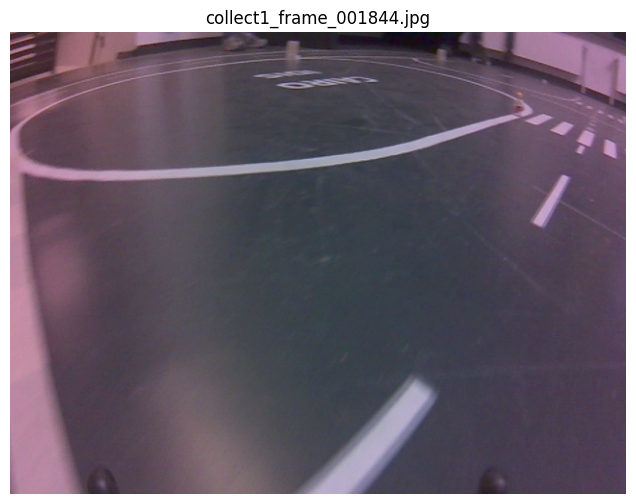

Saved to: /home/supercomputing/studys/smart_car_object_detection/runs/onnx_detect_demo


In [8]:
image_folder = repo_root / 'test_images'
save_dir = repo_root / 'runs' / 'onnx_detect_demo'
save_dir.mkdir(parents=True, exist_ok=True)

count = 0
for img_path in sorted(image_folder.iterdir()):
    if img_path.suffix.lower() not in {'.jpg', '.jpeg', '.png', '.bmp'}:
        continue
    image = cv2.imread(str(img_path))
    if image is None:
        continue
    detections = detector.predict(image, measure_time=measure_time)
    if measure_time and detector.last_inference_time is not None:
        inf_ms = detector.last_inference_time * 1000.0
        fps = 1.0 / detector.last_inference_time if detector.last_inference_time > 0 else float("inf")
        print(f"Inference: {inf_ms:.2f} ms | FPS: {fps:.2f}")
    vis = detector.visualize(image, detections)
    out_path = save_dir / img_path.name
    cv2.imwrite(str(out_path), vis)
    count += 1
    if count >= 100:
        show_bgr(vis, title=img_path.name)
        break

print(f'Saved to: {save_dir}')


## 摄像头检测 (JetRacer / USB)

In [ ]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

camera_handle = {"type": None, "obj": None}

def iter_camera_frames(num_frames=50, width=640, height=480, fps=30):
    try:
        from jetcam.csi_camera import CSICamera
        camera = CSICamera(width=width, height=height, fps=fps)
        camera_handle["type"] = "jetcam"
        camera_handle["obj"] = camera
        for _ in range(num_frames):
            frame = camera.read()
            if frame is None:
                continue
            yield frame
    except Exception:
        cap = cv2.VideoCapture(0)
        camera_handle["type"] = "opencv"
        camera_handle["obj"] = cap
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
        for _ in range(num_frames):
            ok, frame = cap.read()
            if not ok:
                break
            yield frame
        cap.release()


def stop_camera():
    obj = camera_handle.get("obj")
    if obj is None:
        return
    if camera_handle.get("type") == "jetcam":
        if hasattr(obj, "stop"):
            obj.stop()
        if hasattr(obj, "release"):
            obj.release()
    else:
        if hasattr(obj, "release"):
            obj.release()
    camera_handle["obj"] = None

for frame in iter_camera_frames(num_frames=20):
    detections = detector.predict(frame, measure_time=measure_time)
    if measure_time and detector.last_inference_time is not None:
        inf_ms = detector.last_inference_time * 1000.0
        fps = 1.0 / detector.last_inference_time if detector.last_inference_time > 0 else float("inf")
        print(f"Inference: {inf_ms:.2f} ms | FPS: {fps:.2f}")
    vis = detector.visualize(frame, detections)
    clear_output(wait=True)
    plt.figure(figsize=(6, 4))
    plt.imshow(vis[:, :, ::-1])
    plt.axis("off")
    display(plt.gcf())
    plt.close()


In [ ]:
# 停止摄像头资源
try:
    stop_camera()
except NameError:
    pass
